# Toxicity Classification

## Objective:
This notebook covers the news toxicity classification fector in order to detrermine fake news. 
We need to create a model which predicts a probability of each type of toxicity for each comment.

## Dataset
We are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

* toxic
* severe_toxic
* obscene
* threat
* insult
* identity_hate
<br>
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data<br>

# 1. Data input and Cleansing
Loading csv file and doing encoding for

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords  # stop words are, is, the etc. which are not needed for model
from nltk.stem.porter import PorterStemmer
!pip install gensim
from gensim.models import word2vec 
from sklearn.manifold import TSNE

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mk194903/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('../dataset/jigsaw-toxic-comment-classification-challenge/train.csv')
#df_test = pd.read_csv('../dataset/jigsaw-toxic-comment-classification-challenge/test.csv')

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
X = df["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

#Flag for toxic
rowsums=df[possible_labels].sum(axis=1)
df['istoxic'] = rowsums # istoxic is target 0-Clean as number grows more severe toxic
df['clean']=(rowsums==0) #Clean=1 Toxic =0
y = df.istoxic

In [5]:
y.shape

(159571,)

## Data Cleansing

In [7]:
# Corpus cleaning
STOPWORDS = set(stopwords.words('english'))
def clean_str(string):
    """
    Tokenization/string cleaning for datasets.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"^b", "", string)
    string = re.sub(r"\\n ", "", string)
    string = re.sub(r"\'s", "", string)
    string = re.sub(r"\'ve", "", string)
    string = re.sub(r"n\'t", "", string)
    string = re.sub(r"\'re", "", string)
    string = re.sub(r"\'d", "", string)
    string = re.sub(r"\'ll", "", string)
    string = re.sub(r",", "", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", "", string)
    string = re.sub(r"\)", "", string)
    string = re.sub(r"\?", "", string)
    string = re.sub(r"'", "", string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"[0-9]\w+|[0-9]","", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = ' '.join(Word(word).lemmatize() for word in string.split() if word not in STOPWORDS) # delete stopwors from text

    return string.strip().lower()

In [9]:
# Cleaning text
!pip install textblob
import nltk
nltk.download('wordnet')
from textblob import Word
df['comment_text_clean'] = df['comment_text'].apply(lambda x : clean_str(x))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mk194903/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
df['comment_text_clean']

0         explanation why edits made username hardcore m...
1         daww ! he match background colour im seemingly...
2         hey man im really trying edit war it guy const...
3         more i ca make real suggestion improvement i w...
4                     you sir hero any chance remember page
5                   congratulations well use tool well talk
6              cocksucker before you piss around on my work
7         your vandalism matt shirvington article revert...
8         sorry word nonsense offensive anyway im intend...
9                      alignment subject contrary dulithgow
10        fair use rationale image wonju jpg thanks uplo...
11                            bq man let discus maybe phone
12        hey talk what exclusive group wp talibans good...
13        before start throwing accusation warning let r...
14        oh girl started argument she stuck nose belong...
15        juelz santanas age in juelz santana year old c...
16           bye ! do look come think co

In [11]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,istoxic,clean,comment_text_clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,True,explanation why edits made username hardcore m...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,True,daww ! he match background colour im seemingly...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,True,hey man im really trying edit war it guy const...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,True,more i ca make real suggestion improvement i w...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,True,you sir hero any chance remember page


# 2. Feature engineering

In [12]:
## Indirect features

import string
#Sentense count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [13]:
#derived features
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

# 3. Exploratory Data Analysis (EDA)

Lets get some familiarity with the structure and features of the dataset.

A first step would be to look at some random messages with toxicity or not.

In [14]:
df.sample(5, random_state=0)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,istoxic,clean,...,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent
74251,c6a29bad26183dcf,"""\nI haven't paraphrased you at all, Gary. Yo...",0,0,0,0,0,0,0,True,...,56,47,314,19,3,5,27,4.553571,83.928571,33.928571
131406,befd36e7acca9e56,I BLOCKED REVERS! I BLOCKED REVERS! I BLOCKED ...,1,0,0,0,0,0,1,False,...,105,3,629,35,105,35,35,5.000000,2.857143,33.333333
120969,8734c26db56d1763,I'm sorry. I'd like to unreservedly retract my...,0,0,0,0,1,0,1,False,...,57,50,308,8,2,3,28,4.421053,87.719298,14.035088
121827,8bcf03120412d869,I don't know if this is exactly like the Press...,0,0,0,0,0,0,0,True,...,20,19,178,16,1,3,12,7.900000,95.000000,80.000000
4771,0ca7b705720d6956,"Thank you all, we'll all improve the Wikipedia...",0,0,0,0,0,0,0,True,...,130,87,717,11,6,16,61,4.484615,66.923077,8.461538


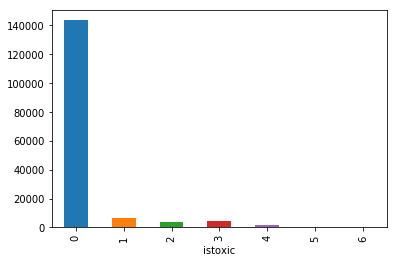

In [15]:
#In our case we just need to categorize on toxicity. Different category of toxicity does not matter. 
df.groupby('istoxic').comment_text_clean.count().plot.bar(ylim=0)

As we see more than 140K messages are clean and around 15K messages have toxic content. Toxicity can be of different kind like "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate".Some messages have two or more kind of toxicity.

### Word Cloud

Now let us look at the frequently occuring words in the data by creating a word cloud on the 'text' column.

#### Word Cloud for Clean Messages

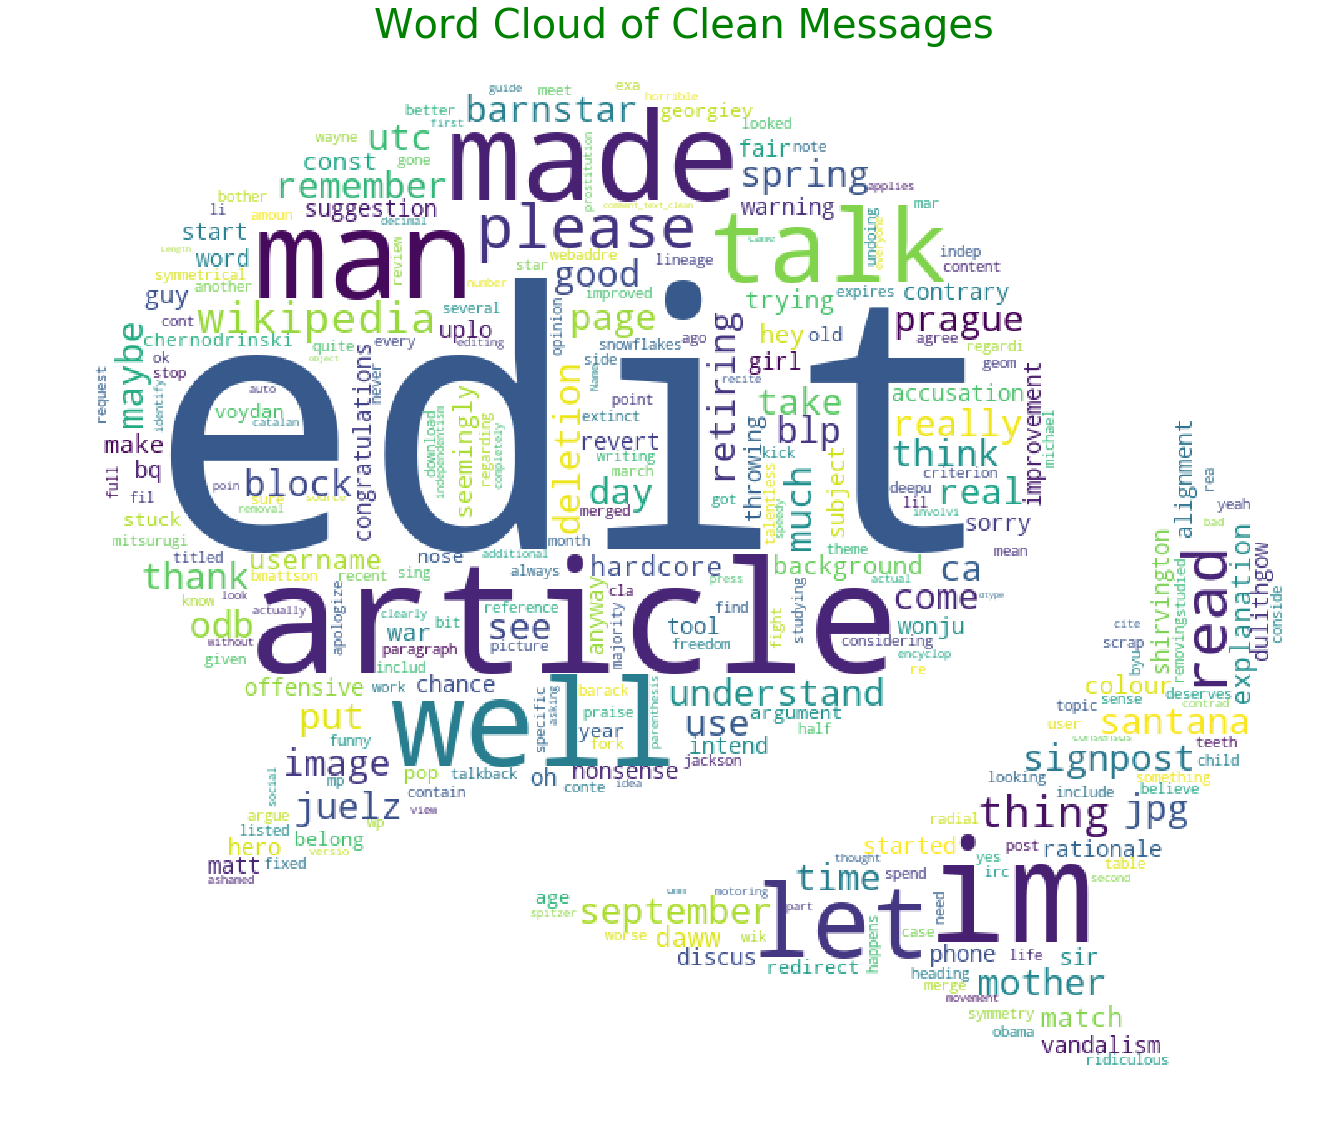

In [16]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS  #install $ pip install wordcloud

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

# word cloud for clean messages
back_img_mask = np.array(Image.open('../images/comment.png'))
plot_wordcloud(df[df["istoxic"]==0]["comment_text_clean"], back_img_mask, max_words=300000, max_font_size=300, title="Word Cloud of Clean Messages")

#### Word Cloud for Toxic Messages

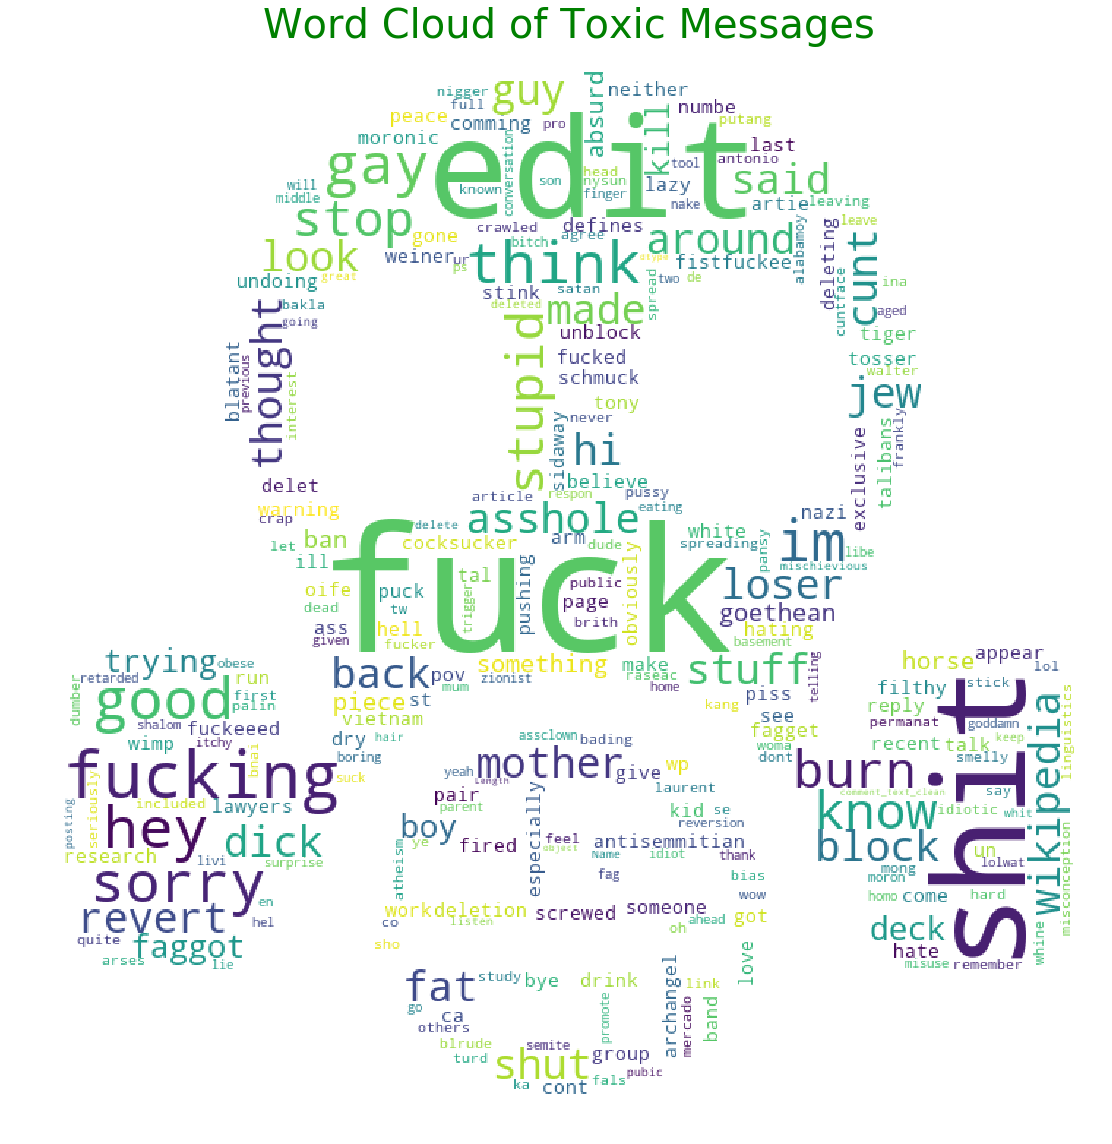

In [17]:
# word cloud for toxic messages
back_img_mask = np.array(Image.open('../images/toxic.png'))
plot_wordcloud(df[df["istoxic"]>0]["comment_text_clean"], back_img_mask, max_words=300000, max_font_size=300, title="Word Cloud of Toxic Messages")

We can clearly see messages are using toxic words. These words were not there in clean text.

#### Are longer comments more toxic?

/Users/mk194903/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/mk194903/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


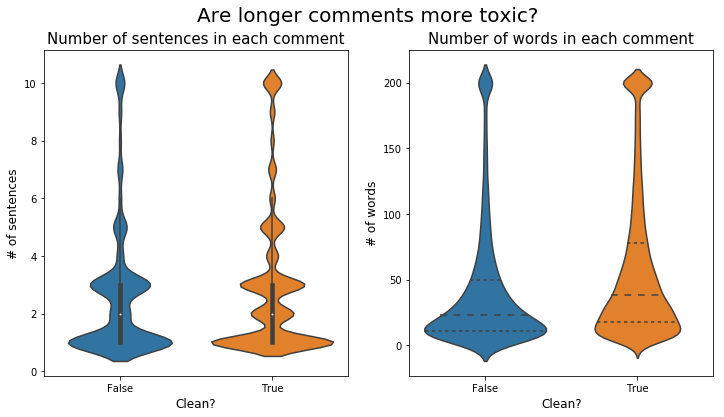

In [18]:
df['count_sent'].loc[df['count_sent']>10] = 10 
plt.figure(figsize=(12,6))
## sentenses
plt.subplot(121)
plt.suptitle("Are longer comments more toxic?",fontsize=20)
sns.violinplot(y='count_sent',x='clean', data=df,split=True)
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of sentences', fontsize=12)
plt.title("Number of sentences in each comment", fontsize=15)
# words
df['count_word'].loc[df['count_word']>200] = 200
plt.subplot(122)
sns.violinplot(y='count_word',x='clean', data=df,split=True,inner="quart")
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in each comment", fontsize=15)

plt.show()

Long sentences or more words do not seem to be a significant indicator of toxicity.

#### Are spammers more toxic?

In [19]:
#spammers - comments with less than 40% unique words
spammers=df[df['word_unique_percent']<30]

print("Clean Spam example:")
print(spammers[spammers.clean==1].comment_text.iloc[1])
print("Toxic Spam example:")
print(spammers[spammers.clean<1].comment_text.iloc[2])

Clean Spam example:
Towns and Villages in Ark-La-Tex]]
 Cities, boroughs and towns in the Republic of Ireland
 Cities, boroughs, and townships along the Susquehanna River
 Cities, towns and villages in Alborz Province
 Cities, towns and villages in Ardabil Province
 Cities, towns and villages in Bhutan
 Cities, towns and villages in Bushehr Province
 Cities, towns and villages in Chaharmahal and Bakhtiari Province
 Cities, towns and villages in Cyprus
 Cities, towns and villages in Dutch Limburg
 Cities, towns and villages in East Azerbaijan Province
 Cities, towns and villages in East Timor
 Cities, towns and villages in Fars Province
 Cities, towns and villages in Flevoland
 Cities, towns and villages in Friesland
 Cities, towns and villages in Gelderland
 Cities, towns and villages in Gilan Province
 Cities, towns and villages in Golestan Province
 Cities, towns and villages in Groningen
 Cities, towns and villages in Hamadan Province
 Cities, towns and villages in Hormozgan Provinc

Spam messages are more toxic.

# 4. Model Training and Validation

Lets train model and validate.

## Doc2vec and Logistic Regression

In [20]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

In [21]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

In [22]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.comment_text_clean, df.istoxic, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_text = X_train + X_test

In [23]:
all_text[:4]

[TaggedDocument(words=['actually', 'know', 'im', 'using', 'account', 'anymore', 'i', 'always', 'tried', 'good', 'contributer', 'damn', 'elitism', 'pissing', 'maybe', 'i', 'make', 'new', 'account', 'maybe', 'i', 'start', 'ip', 'editing', 'but', 'never', 'know'], tags=['Train_0']),
 TaggedDocument(words=['the', 'problem', 'disambig', 'michael', 'link', 'event', 'history', 'barely', 'called', 'polish', 'invasion', 'russia', 'instance', 'russia', 'today', 'meaning', 'word', 'show', 'rather', 'russian', 'ghirlandajo', 'pov', 'without', 'disclamer', 'term', 'used', 'russian', 'historiography', 'reader', 'think', 'claim', 'polish', 'invasion', 'russia', 'exactly', 'view', 'that', 'main', 'problem', 'ghirlandajo', 'insult', 'weak', 'explanation', 'afterwards', 'understood', 'wrongly', 'yeah', 'right', 'make', 'finding', 'good', 'solution', 'difficult', 'best'], tags=['Train_1']),
 TaggedDocument(words=['legalleft', 'i', 'guess', 'sarcasm', 'one', 'characteristic', 'developed', 'either', 'gene'

In [24]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_text)])

100%|██████████| 159571/159571 [00:00<00:00, 1973885.44it/s]


In [25]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_text)]), total_examples=len(all_text), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 159571/159571 [00:00<00:00, 2817289.09it/s]


In [26]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [27]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

## Model Training

In [28]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)

/Users/mk194903/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mk194903/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [29]:
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

/Users/mk194903/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mk194903/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [30]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

## Validation

In [45]:
%%time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.9136238302139037
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     42984
           1       0.34      0.13      0.19      1930
           2       0.19      0.01      0.02      1061
           3       0.46      0.47      0.47      1253
           4       0.35      0.13      0.19       513
           5       0.23      0.04      0.07       123
           6       0.05      0.25      0.08         8

   micro avg       0.91      0.91      0.91     47872
   macro avg       0.37      0.29      0.28     47872
weighted avg       0.88      0.91      0.89     47872

CPU times: user 35.8 ms, sys: 5.04 ms, total: 40.8 ms
Wall time: 43.2 ms


In [46]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[42803   117     4    43     2     1    14]
 [ 1536   253    16   103    14     2     6]
 [  668   166    13   195    15     1     3]
 [  421   140    25   592    58     6    11]
 [   81    55     8   288    69     7     5]
 [   15     8     1    52    39     5     3]
 [    1     1     0     3     1     0     2]]


LogisticRegression is having very good accuracy of around 91%.

# Load Original fake news data to add feature

In [32]:
df1 = pd.read_csv('../dataset/fake_real_dataset_spam_category.csv')

In [33]:
def combine_column(tuple1):
    if(pd.notna(tuple1[1])):
        if(tuple1[1].strip(' \t\n\r') == ''):
            return 'NA'
        else:
            return tuple1[1]
    elif(pd.notna(tuple1[0])):
        if(tuple1[0].strip(' \t\n\r') == ''):
            return 'NA'
        else:
            return tuple1[0]   
    else:
            return 'NA'

In [34]:
df1['content'] = df1[['title', 'text']].apply(combine_column, axis=1)

In [35]:
#Cleansing
df1['content'] = df1['content'].apply(lambda x : clean_str(x))

In [36]:
#Doc2Vec
test1_vectors_dbow = get_vectors(model_dbow, len(df1['content']), 300, 'Test')

In [37]:
#predictions
output1 = logreg.predict(test1_vectors_dbow)

In [38]:
df1['toxicity_fector'] = pd.DataFrame(data=output1, columns=['toxicity_fector'])

In [39]:
df1.sample(5, random_state=0)

,Unnamed: 0,Unnamed: 0.1,uuid,ord_in_thread,author,published,title,text,language,crawled,...,replies_count,participants_count,likes,comments,shares,type,content,spam_score_fector,category_fector,toxicity_fector
1095,1095,1095,e2a9b33da3c30f2d576645416d4f91bbdb790962,0,BareNakedIslam,2016-11-06T23:08:05.041+02:00,"GERMANY: Bigger than the Berlin Wall, the 12-f...",BNI Store Nov 6 2016 GERMANY: Bigger than the ...,english,2016-11-06T23:08:05.041+02:00,...,0,1,0,0,0,bs,bni store nov germany bigger berlin wall foot ...,0.997050,politics,0
248,248,248,5fccb20a0257e0d9fd1e1df51d43352f73288fdd,0,JinMI,2016-10-28T06:57:21.454+03:00,Oregon Standoff Leaders Acquitted For Malheur ...,Oregon Standoff Leaders Acquitted For Malheur ...,english,2016-10-28T06:57:21.454+03:00,...,0,1,0,0,0,bs,oregon standoff leaders acquitted for malheur ...,0.973779,business,0
688,688,688,3144f77474072fe03b136d63e83a472b35dec307,0,Alex Ansary,2016-11-07T20:01:08.775+02:00,Hillary Clinton in lead a day before Election Day,Hillary Clinton in lead a day before Election ...,english,2016-11-07T20:01:08.775+02:00,...,0,1,0,0,0,bs,hillary clinton lead day election day press tv...,0.970459,politics,0
2128,2128,2128,e93ca1c6fc0ec4bbcc786b72e5449b75a16556fe,0,The Associated Press,2016-11-08T23:13:00.000+02:00,IN-StHou-56-elected - SFGate,NaN,english,2016-11-09T06:12:01.559+02:00,...,0,0,0,0,0,news,in sthou elected sfgate,0.866053,sport,0
1170,1170,1170,6c9b8c99ce5cbb1543bff3265bbb5c1b5460cf26,0,beforeitsnews.com,2016-10-26T18:25:00.000+03:00,It is Time for Hillary Clinton to Duck and Go ...,(Before It's News)\r\n(image credit: Justin Su...,english,2016-10-26T22:06:55.438+03:00,...,0,1,1,0,1,bs,before it news image credit justin sullivan ge...,0.929635,politics,0


In [40]:
df1.to_csv('../dataset/fake_real_dataset_spam_category_toxicity.csv')

In [41]:
#Clean Up container
#!rm 'fake_real_dataset_spam (2).csv'
#!rm *.*
#!ls

In [42]:
!pwd


/Users/mk194903/Desktop/Projects/ML/Jupyter/MachineLearningModels/NLP_FakeNews


## Reference
https://github.com/manojknit/Natural_Language_Processing/blob/master/Topic%20Modeling%20t-SNE%20and%20Visualization.ipynb <br>
https://cloud.google.com/blog/products/gcp/problem-solving-with-ml-automatic-document-classification<br>
https://www.kaggle.com/nlothian/fake-news-nlp-stuff

[Multi-Class Text Classification Model Comparison and Selection](https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568)<br>
[Topic Modeling with LSA, PLSA, LDA & lda2Vec](https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05)<br>
[Stop the S@# - Toxic Comments EDA](https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda)